In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
import types

import data_jat as data


This unreleased version of SpacePy is not supported by the SpacePy team.


In [2]:
def weighted_avg(data, axis=0, weights=None, unc=False):
    """From Jon.  (Thanks Jon.)"""
    if weights is None:
        weights = np.empty(shape=data.shape, dtype=np.float64)
        weights.fill(1.)
    else:
        weights = weights.copy()
    data = data.copy()
    
    # Make NaN "disappear" from weights and input
    nanidx = np.isnan(data)
    weights[nanidx] = 0
    data[nanidx] = 0
    
    if unc:
        data = data ** 2
    sum_ = np.sum(data * weights, axis=axis)
    counts = np.sum(weights, axis=axis)
    
    if unc:
        sum_ = np.sqrt(sum_)
        
    # If there are no counts after averaging, then nan the output
    if len(sum_.shape) > 0:
        nocountidx = (counts == 0)
        counts[nocountidx] = 1
        sum_[nocountidx] = np.nan
    mean = sum_ / counts
    
    return mean


In [3]:
background = data.Data('joyce-apj-background')
background.read_data(force_cache=True)


Found cached data from file eventdata_joyce-apj-background_20210812.pickle3.bz2, using contents...


In [4]:
l = list()
r = list()
u = list()


for i, event in enumerate(background.eventdata):
    e = types.SimpleNamespace(**copy.deepcopy(event['ChanP']))
    
    lookdir_idx = np.zeros((80), dtype=bool)
    lookdir_idx[20:50] = True
    lookdir_idx[np.array((25, 31, 34, 35, 44))] = False    
    
    fluxbad = np.isnan(e.flux)
    fluxbad = np.min(fluxbad[:, lookdir_idx, :], axis=1)
    fluxbad = np.min(fluxbad, axis=1)
    fluxgood = ~fluxbad

    l.append(np.sum(e.epoch_delta[fluxgood]) * 2)

    """
    From Colin:
    
    > -For each energy bin and look direction, do the sum of (flux * delta t)
    > over the entire quiet period, then divide by the total time of the quiet
    > period (including the half delta-t at each end?) Is there any fill in
    > the flux for this? Dividing by the total time if some time bins are fill
    > would tend to decrease the flux (treating fill as zero).

    Correct. I believe at that time, I did treat fills as zeros rather than removing the
    points, which would have been better.
    """
    # weighted average in time
    weights = e.epoch_delta
    # make weights the right dimensionality
    weights = np.tile(weights[:, None, None], (1,) + e.flux.shape[1:])
    for a in ('flux', 'energy_unc_plus', 'energy_unc_minus'):
        setattr(e, a, weighted_avg(getattr(e, a), weights=weights, axis=0))
    weights_unc = weights / np.nanmean(weights)
    setattr(e, 'flux_unc', weighted_avg(getattr(e, 'flux_unc'), weights=weights_unc, axis=0, unc=True))
   
    # make sure the time axis is gone:
    assert(len(e.flux.shape) == 2)
    
    # get only lookdirs of interest and do lookdir average
    for a in ('flux', 'energy_unc_plus', 'energy_unc_minus'):
        setattr(e, a, np.nanmean(getattr(e, a)[lookdir_idx, :], axis=0))
    setattr(e, 'flux_unc', weighted_avg(getattr(e, 'flux_unc')[lookdir_idx, :], axis=0, unc=True))
        
    # make sure the lookdir axis is gone:
    assert(len(e.flux.shape) == 1)
    
    r.append(e.flux * 1e3)  # times 1e3 to go from per keV to per MeV
    u.append(e.flux_unc * 1e3)
    
    # this is a little dirty, (especially because it'll continuously be redfined) but it should work fine
    ebin_widths = (e.energy_unc_plus + e.energy_unc_minus) / 1e3


# calculate mean flux and error; need to reshape some stuff for weights/binning
r = np.stack(r, axis=0)
u = np.stack(u, axis=0)
    
w = np.array(l)
w = w / np.nanmean(w)
w = np.tile(w[:, None], (1,) + u.shape[1:])

background_avg = weighted_avg(r, weights=w, axis=0)
background_err = weighted_avg(u, axis=0, weights=w, unc=True)
# grab the most recent bins because they're all the same anyway (at least they should be)
ebins = e.energy[0, 0, :] / 1e3


/home/asher/.miniconda3/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice


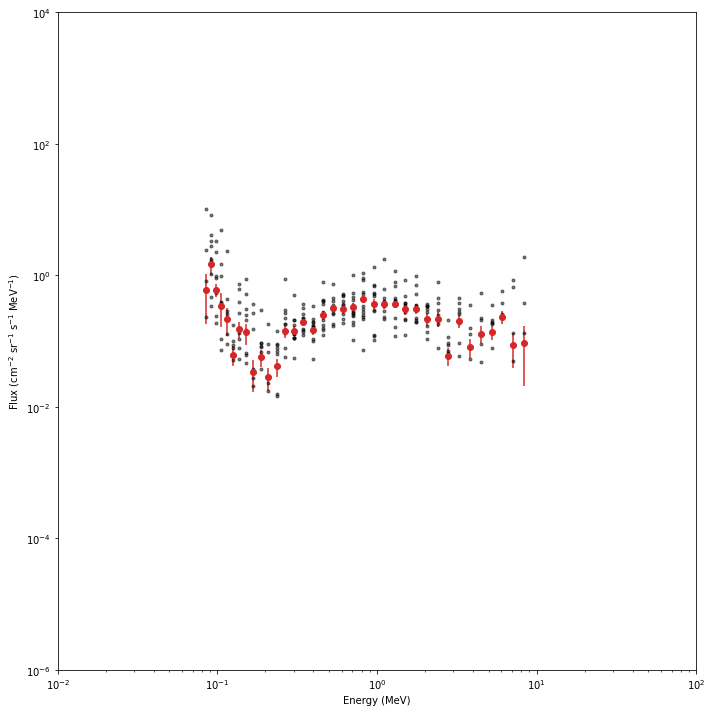

In [5]:
plt.figure(figsize=(10, 10))
plt.xlabel('Energy (MeV)')
plt.xscale('log')
plt.xlim(10e-3, 1e2)
plt.ylabel('Flux (cm$^{-2}$ sr$^{-1}$ s$^{-1}$ MeV$^{-1})$')
plt.yscale('log')
plt.ylim(1e-6, 1e4)

for f in r:
    plt.plot(ebins, f, '.k', alpha=0.5)  # already scaled by 1e3
plt.errorbar(ebins, background_avg, yerr=background_err, marker='o', color='tab:red', linestyle='')

plt.tight_layout()

plt.savefig('figures/joyce-apj-fig1-closecolors.png', dpi=600)
plt.show()


In [6]:
events = data.Data('joyce-apj-events')
events.read_data(force_cache=True)

quiettimes = data.Data('joyce-apj-event-quiettimes')
quiettimes.read_data(force_cache=True)


Found cached data from file eventdata_joyce-apj-events_20210812.pickle3.bz2, using contents...
Found cached data from file eventdata_joyce-apj-event-quiettimes_20210812.pickle3.bz2, using contents...


In [7]:
r = list()
u = list()


for i, event in enumerate(events.eventdata):
    e = types.SimpleNamespace(**copy.deepcopy(event['ChanP']))
    
    lookdir_idx = np.zeros((80), dtype=bool)
    lookdir_idx[20:50] = True
    lookdir_idx[np.array((25, 31, 34, 35, 44))] = False    
    
    fluxbad = np.isnan(e.flux)
    fluxbad = np.min(fluxbad[:, lookdir_idx, :], axis=1)
    fluxbad = np.min(fluxbad, axis=1)
    fluxgood = ~fluxbad

    # weighted average in time
    weights = e.epoch_delta
    # make weights the right dimensionality
    weights = np.tile(weights[:, None, None], (1,) + e.flux.shape[1:])
    for a in ('flux', 'energy_unc_plus', 'energy_unc_minus'):
        setattr(e, a, weighted_avg(getattr(e, a), weights=weights, axis=0))
    weights_unc = weights / np.nanmean(weights)
    setattr(e, 'flux_unc', weighted_avg(getattr(e, 'flux_unc'), weights=weights_unc, axis=0, unc=True))

    # get only lookdirs of interest and do lookdir average
    for a in ('flux', 'energy_unc_plus', 'energy_unc_minus'):
        setattr(e, a, np.nanmean(getattr(e, a)[lookdir_idx, :], axis=0))
    setattr(e, 'flux_unc', weighted_avg(getattr(e, 'flux_unc')[lookdir_idx, :], axis=0, unc=True))

    r.append(e.flux * 1e3)  # times 1e3 to go from per keV to per MeV
    u.append(e.flux_unc * 1e3)

    
events_avg = np.stack(r, axis=0)
events_err = np.stack(u, axis=0)


/home/asher/.miniconda3/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice


In [8]:
r = list()
u = list()


for i, event in enumerate(quiettimes.eventdata):
    e = types.SimpleNamespace(**copy.deepcopy(event['ChanP']))
    
    lookdir_idx = np.zeros((80), dtype=bool)
    lookdir_idx[20:50] = True
    lookdir_idx[np.array((25, 31, 34, 35, 44))] = False    
    
    fluxbad = np.isnan(e.flux)
    fluxbad = np.min(fluxbad[:, lookdir_idx, :], axis=1)
    fluxbad = np.min(fluxbad, axis=1)
    fluxgood = ~fluxbad

    # weighted average in time
    weights = e.epoch_delta
    # make weights the right dimensionality
    weights = np.tile(weights[:, None, None], (1,) + e.flux.shape[1:])
    for a in ('flux', 'energy_unc_plus', 'energy_unc_minus'):
        setattr(e, a, weighted_avg(getattr(e, a), weights=weights, axis=0))
    weights_unc = weights / np.nanmean(weights)
    setattr(e, 'flux_unc', weighted_avg(getattr(e, 'flux_unc'), weights=weights_unc, axis=0, unc=True))

    # get only lookdirs of interest and do lookdir average
    for a in ('flux', 'energy_unc_plus', 'energy_unc_minus'):
        setattr(e, a, np.nanmean(getattr(e, a)[lookdir_idx, :], axis=0))
    setattr(e, 'flux_unc', weighted_avg(getattr(e, 'flux_unc')[lookdir_idx, :], axis=0, unc=True))

    r.append(e.flux * 1e3)  # times 1e3 to go from per keV to per MeV
    u.append(e.flux_unc * 1e3)

    
quiettimes_avg = np.stack(r, axis=0)
quiettimes_err = np.stack(u, axis=0)


/home/asher/.miniconda3/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice


In [9]:
ebin_weights = ebin_widths / np.nanmean(ebin_widths)


In [10]:
fit_points = np.zeros(((len(events_avg),) + ebins.shape), dtype=bool)
# fit_points[:, :26] = True  # by default, only use 60 to 800 kev for fitting
fit_points[:, 3:22] = True  # seems to only include the parts of the distribution that is approximately power-law-ish

# fit_points[0, :] = False
# fit_points[0, 5:22] = True  # messing around with fit indices with Jon

# fit_fn = lambda f, j_0, j_d, p: j_0 * (f - j_d) ** p
fit_fn = lambda f, j_0, p: j_0 * f ** p
fit_dom = np.logspace(-2, 2)


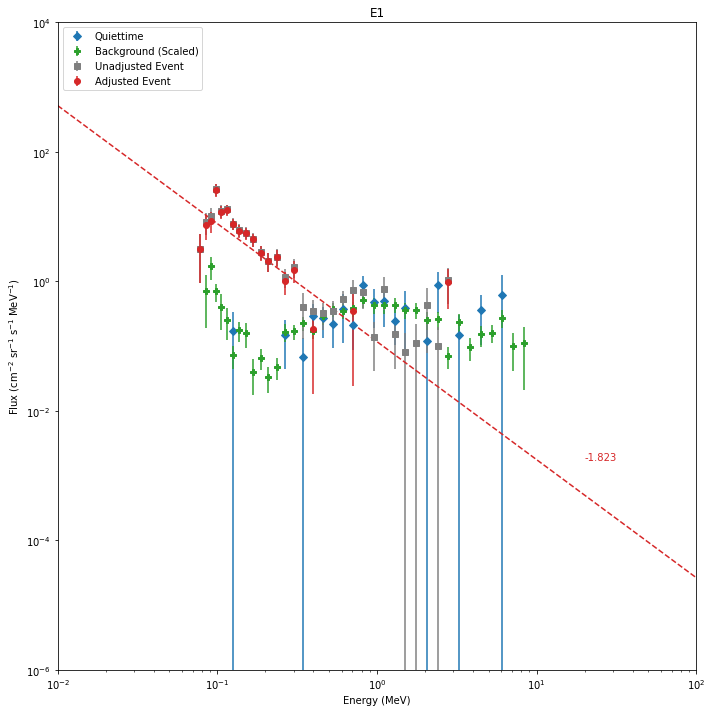

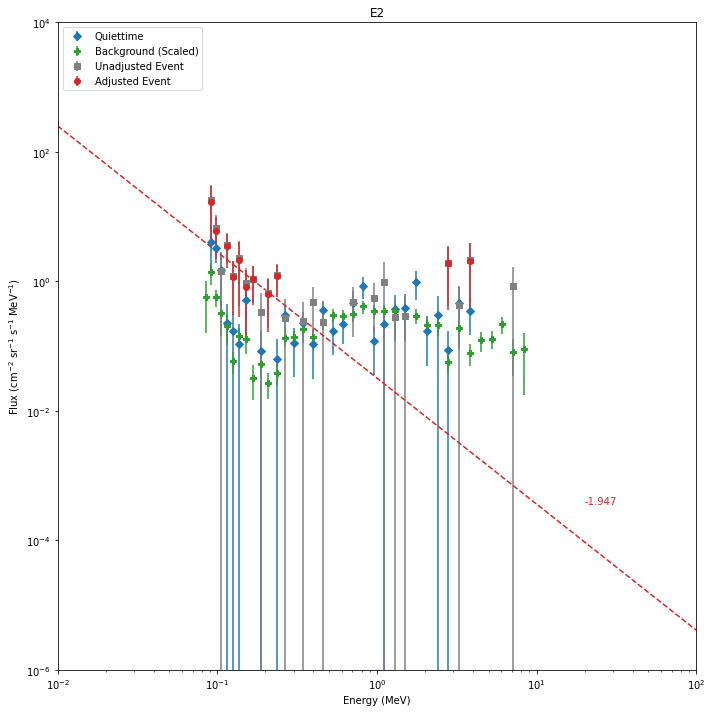

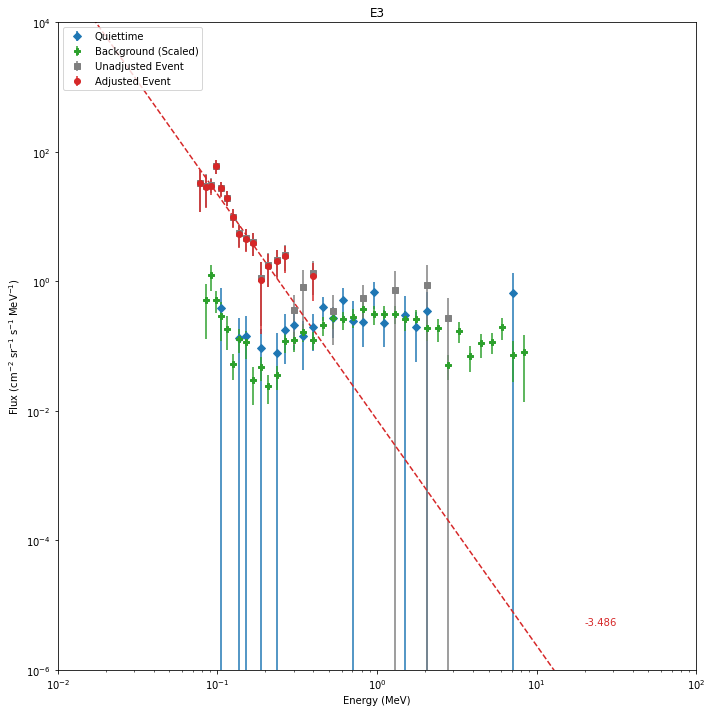

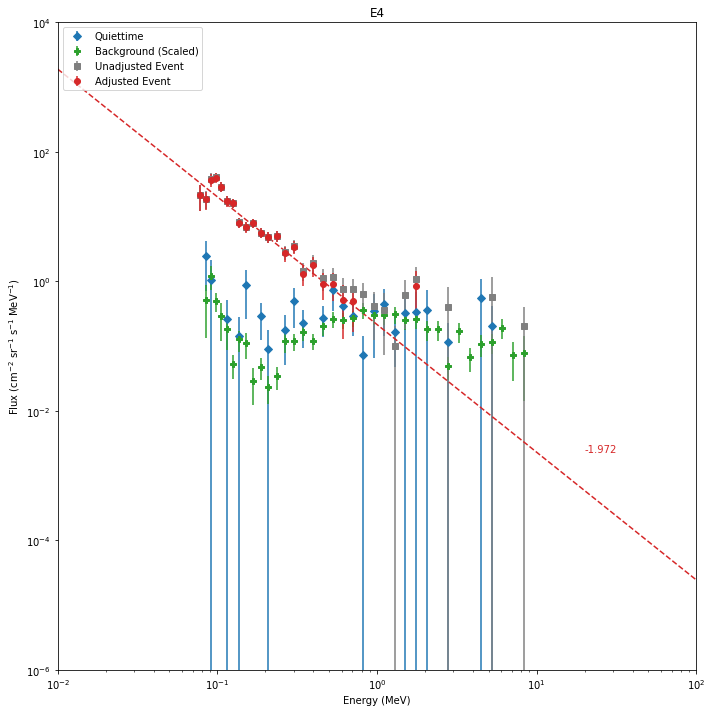

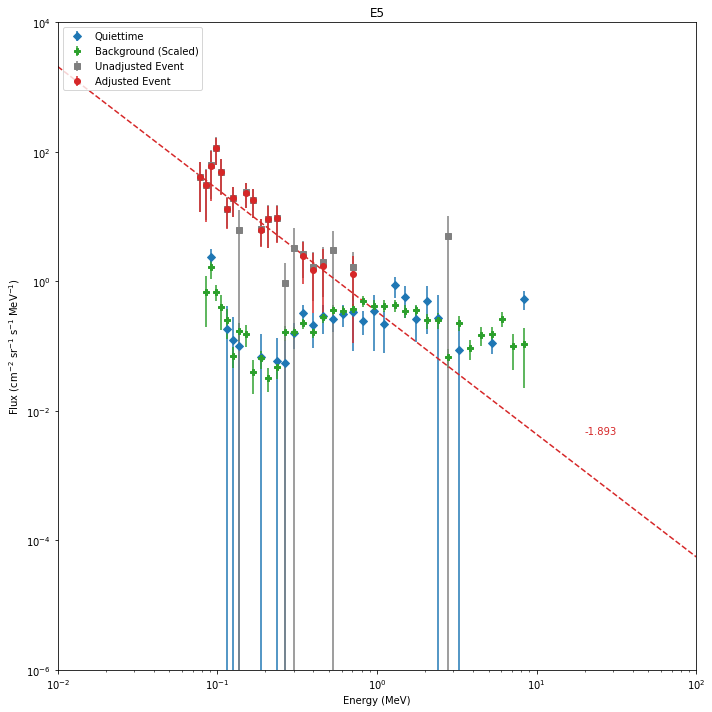

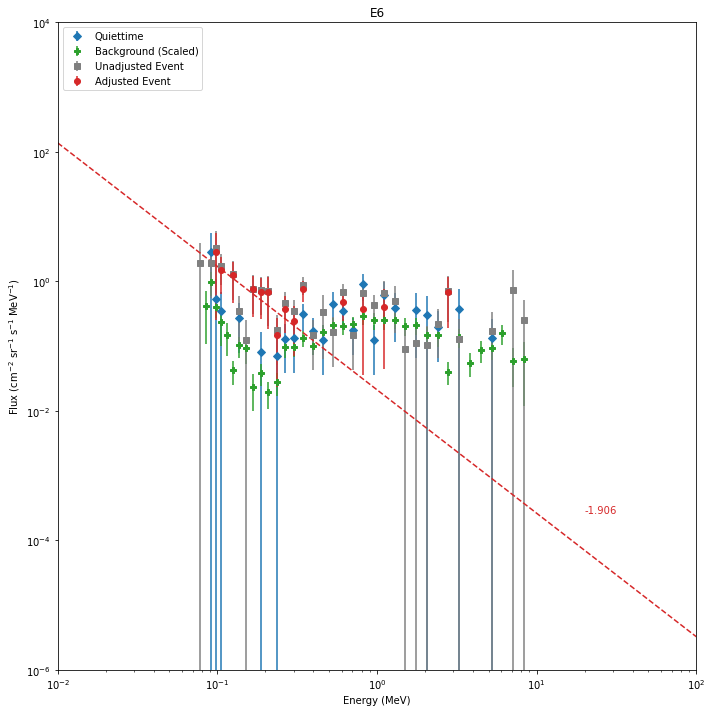

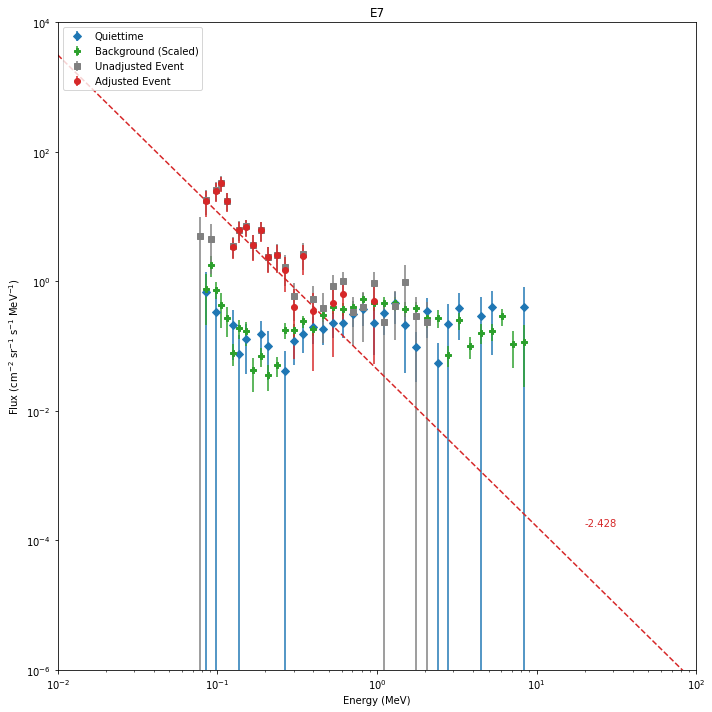

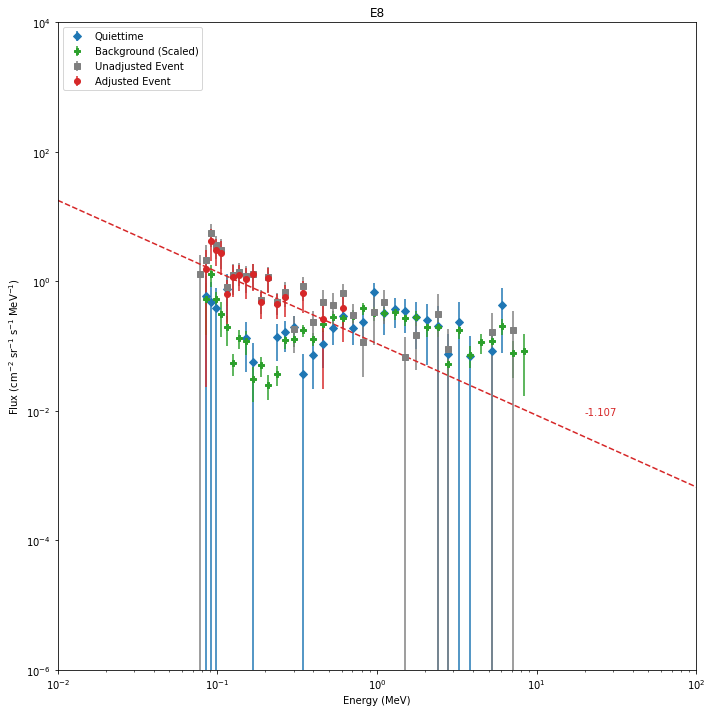

In [11]:
for i in range(len(events_avg)):
    # calculate scaling factor of background
#     scale = weighted_avg(background_avg, weights=ebin_weights) / weighted_avg(quiettimes_avg[i], weights=ebin_weights)
#     scale_err = (background_err / background_avg - quiettimes_err[i] / quiettimes_avg[i]) * scale
    
    bg_bar = weighted_avg(background_avg, weights=ebin_weights)
    bg_bar_err = weighted_avg(background_err, unc=True, weights=ebin_weights)
    qt_bar = weighted_avg(quiettimes_avg[i], weights=ebin_weights)
    qt_bar_err = weighted_avg(quiettimes_err[i], unc=True, weights=ebin_weights)    
    
    """
    scale_err = sqrt(
        (d_scale / d_bg_bar * bg_bar_err) ** 2 + 
        (d_scale / d_qt_bar * qt_bar_err) ** 2
    )
    
    this is equal to
    
    scale_err = sqrt(
        (bg_bar_err / qt_bar) ** 2 +
        (-1 * bg_bar / qt_bar ** 2 * qt_bar_err) ** 2
    )    
    """

    scale = bg_bar / qt_bar
    scale_err = np.sqrt(
        (bg_bar_err / qt_bar) ** 2 +
        (-1 * bg_bar / qt_bar ** 2 * qt_bar_err) ** 2
    )
       

    """
    event_adj_err = sqrt(
        events_err[i] ** 2 +
        (-1 / scale * bg_bar_err) ** 2 +
        (bg_bar / scale ** 2 * scale_err) ** 2
    )
    """
    event_adj = events_avg[i] - background_avg / scale
    event_adj_err = np.sqrt(
        events_err[i] ** 2 +
        (-1 / scale * background_err) ** 2 +
        (background_avg / scale ** 2 * scale_err) ** 2
    )

    # do the cutout
    event_adj[event_adj < event_adj_err] = np.nan
    event_adj[event_adj <= 0] = np.nan
    
    notnan = np.logical_and(~np.isnan(event_adj), fit_points[i])
    
    # do the fit
    popt, pcov = scipy.optimize.curve_fit(
        fit_fn,
        ebins[notnan],
        event_adj[notnan],
        sigma=events_err[i][notnan],
        maxfev=int
        (
            1e4
        )
    )
    
    plt.figure(figsize=(10, 10))
    plt.xlabel('Energy (MeV)')
    plt.xscale('log')
    plt.xlim(10e-3, 1e2)
    plt.ylabel('Flux (cm$^{-2}$ sr$^{-1}$ s$^{-1}$ MeV$^{-1})$')
    plt.yscale('log')
    plt.ylim(1e-6, 1e4)

    # background
    plt.errorbar(ebins, quiettimes_avg[i], yerr=quiettimes_err[i], color='tab:blue', linestyle='', marker='D', label='Quiettime')
    plt.errorbar(ebins, background_avg / scale, 
                 yerr=np.sqrt((1 / scale * background_err)**2 + (-1 * background_avg / scale**2 * scale_err)**2),
                 color='tab:green', linestyle='', marker='P', label='Background (Scaled)')
    
    # event and adjusted event
    plt.errorbar(ebins, events_avg[i], yerr=events_err[i], marker='s', color='gray', linestyle='', label='Unadjusted Event')
    plt.errorbar(ebins, event_adj, yerr=event_adj_err, marker='o', color='tab:red', linestyle='', label='Adjusted Event')

    # powerlaw
    plt.plot(fit_dom, fit_fn(fit_dom, *popt), marker='', linestyle='--', color='tab:red')
    plt.text(2e1, max(fit_fn(1e1, *popt), 5e-6), f'{popt[-1]:.3f}', color='tab:red')
    
    plt.title('E{}'.format(i + 1))
    plt.legend(loc='upper left')
    plt.tight_layout()

    plt.savefig(f'figures/joyce-apj-fig3.{i + 1}.png')
    plt.show()
